In [15]:
import platform

In [17]:
platform.platform()

'macOS-14.2.1-arm64-arm-64bit'

In [9]:
!python3 -m venv ~/venv-metal

In [11]:
!source ~/venv-metal/bin/activate

In [15]:
!python -m pip install -U pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
  Attempting uninstall: pip
    Found existing installation: pip 24.0
    Uninstalling pip-24.0:
      Successfully uninstalled pip-24.0


In [17]:
!python -m pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 MB 7.2 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 8.9 MB/s eta 0:00:009.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 3.9 MB/s eta 0:00:000:00:010:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.3 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [1]:
import tensorflow as tf
tf.__version__

'2.18.0'

# 1.将训练数据和检测数据加载到内存中(第一次运行需要下载数据，会比较慢):
train_images是用于训练系统的手写数字图片;
train_labels是用于标注图片的信息;
test_images是用于检测系统训练效果的图片；
test_labels是test_images图片对应的数字标签。


In [56]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print('train_images.shape = ',train_images.shape)
print('tran_labels = ', train_labels)
print('test_images.shape = ', test_images.shape)
print('test_labels', test_labels)

train_images.shape =  (60000, 28, 28)
tran_labels =  [5 0 4 ... 5 6 8]
test_images.shape =  (10000, 28, 28)
test_labels [7 2 1 ... 4 5 6]


# 2. 打印用于测试的图片

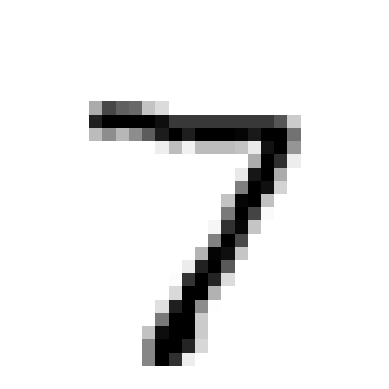

In [58]:
digit = test_images[0]
import matplotlib.pyplot as plt
plt.imshow(digit, cmap=plt.cm.binary)
plt.axis('off')
plt.show()

# 3.使用tensorflow.Keras搭建一个有效识别图案的神经网络，
1. layers:表示神经网络中的一个数据处理层。(dense:全连接层)
2. models.Sequential():表示把每一个数据处理层串联起来.
3. layers.Dense(…):构造一个数据处理层。
4. input_shape(28*28,):表示当前处理层接收的数据格式必须是长和宽都是28的二维数组，后面的“,“表示数组里面的每一个元素到底包含多少个数字都没有关系.
5. network.compile() 的作用：compile() 是 Keras 中用于配置模型的函数。在训练模型之前，需要通过它指定：
    - 优化器（如何更新权重）
    - 损失函数（衡量模型输出与目标值的差距）
    - 评估指标（用于评估模型性能）

In [34]:
from tensorflow.keras import models
from tensorflow.keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28*28,)))
network.add(layers.Dense(10, activation='softmax'))

network.compile(optimizer='rmsprop', loss='categorical_crossentropy',
               metrics=['accuracy'])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# 4. 在把数据输入到网络模型之前，把数据做归一化处理
1. reshape(60000, 28\*28）:train_images数组原来含有60000个元素，每个元素是一个28行，28列的二维数组，
现在把每个二维数组转变为一个含有28\*28个元素的一维数组.
2. 由于数字图案是一个灰度图，图片中每个像素点值的大小范围在0到255之间.
3. train_images.astype(“float32”)/255 把每个像素点的值从范围0-255转变为范围在0-1之间的浮点值。

In [23]:
train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype('float32') / 255

把图片对应的标记也做一个更改：

目前所有图片的数字图案对应的是0到9。

例如test_images\[0]对应的是数字7的手写图案，那么其对应的标记test_labels\[0]的值就是7。

我们需要把数值7变成一个含有10个元素的数组，然后在第8个元素设置为1，其他元素设置为0。

例如test_lables\[0] 的值由7转变为数组\[0,0,0,0,0,0,0,1,0,0] ---one hot

In [27]:
from tensorflow.keras.utils import to_categorical
print("before change:" ,test_labels[0])
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print("after change: ", test_labels[0])

before change: 7
after change:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


# 5. 训练
- train_images：用于训练的手写数字图片；
- train_labels：对应的是图片的标记；
- batch_size：每次网络从输入的图片数组中随机选取128个作为一组进行计算。
- epochs: 每次计算的循环是五次

In [36]:
network.fit(train_images, train_labels, epochs=5, batch_size = 128)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8735 - loss: 0.4407
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9667 - loss: 0.1138
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9783 - loss: 0.0723
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9852 - loss: 0.0503
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9892 - loss: 0.0370


# 6. 测试数据，检验学习后的图片识别效果
识别效果与硬件（CPU/GPU）有关

In [41]:
test_loss, test_acc = network.evaluate(test_images, test_labels, verbose=1)
print(test_loss) 
print('test_acc', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9778 - loss: 0.0730
0.060919299721717834
test_acc 0.9817000031471252


# 7. 输入一张手写数字图片，查看识别效果

In [150]:
import numpy as np
import cv2  # OpenCV 用于图像处理
image_path = "picture.png"  # 替换为实际图片路径
img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  # 读取原始图像，保持4通道
rgb = img[:, :, :3]
gray_img = 0.2989 * rgb[:, :, 0] + 0.5870 * rgb[:, :, 1] + 0.1140 * rgb[:, :, 2]
resized_img = cv2.resize(gray_img, (28, 28), interpolation=cv2.INTER_AREA)
flattened_array = resized_img.flatten()
final_array = flattened_array.reshape(1, -1)

In [152]:
res = network.predict(final_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [154]:
for i in range(res[0].shape[0]):
    if (res[0][i] == 1):
        print("the number for the picture is : ", i)
        break

the number for the picture is :  3


In [116]:
import cv2
# test_image = img.reshape((1000000, 28*28))
rgb = img[:, :, :3]
# 使用灰度公式转换
gray_img = 0.2989 * rgb[:, :, 0] + 0.5870 * rgb[:, :, 1] + 0.1140 * rgb[:, :, 2] * 255
# 2. 调整尺寸为 28x28
resized_img = cv2.resize(gray_img, (28, 28), interpolation=cv2.INTER_AREA)
test_image = resized_img.reshape((1, 28*28))

In [84]:
res = network.predict(test_image)
print("the number for the picture is : ", res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
the number for the picture is :  [[5.8776024e-04 4.3954285e-12 3.0337956e-03 4.2990020e-01 1.0440487e-10
  4.7964576e-01 5.6599438e-06 3.7058842e-07 7.8779176e-02 8.0473293e-03]]


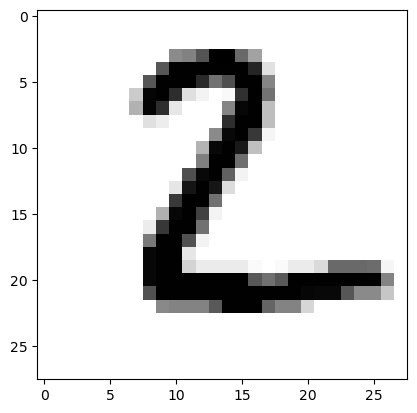

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
the number for the picture is :  2


In [94]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
digit = test_images[1]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()
test_images = test_images.reshape((10000, 28*28))
res = network.predict(test_images)
print(res)

for i in range(res[1].shape[0]):
    if (res[1][i] == 1):
        print("the number for the picture is : ", i)
        break